In [9]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                            get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels
from GGH.imputation_methods import Imputer
import warnings
warnings.filterwarnings('ignore')

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, dropout = 0.05, lr = 0.004, nu = 0.1, final_analysis = False):
       
    AM = AlgoModulators(DO, lr = lr, nu = nu)
    dataloader = DO.prep_dataloader(use_info, batch_size)

    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout = dropout) 

    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, results_path, final_analysis = final_analysis)
    TVM.train_model(DO, AM, model, final_analysis = final_analysis)

    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = final_analysis)
    
    return DO, TVM, model

def multi_experiments(total_runs, use_info, num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                      INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters, final_analysis = True):
    
    progress_bar = tqdm(total=total_runs)
    for r_state in range(2000): #
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                            hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"], final_analysis)
            progress_bar.update(1)
        if progress_bar.n == total_runs:
            break       
    progress_bar.close()

In [2]:
#User requiered data and parameters
data_path = '../data/airfoil_self_noise/data.csv'
results_path = "../saved_results/Airfoil Noise"
inpt_vars = ['frequency', 'attack-angle', 'free-stream-velocity', 'suction-side-displacement-thickness'] # 'chord-length',
target_vars = ['scaled-sound-pressure']
miss_vars = ['chord-length']
hypothesis = [[0.0254, 0.0508, 0.1016, 0.1524, 0.2286, 0.3048]]

#Percentage of simulated data with full information
partial_perc = 0.04
rand_state = 42

#Model Train Parameters
hidden_size = 32

batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

#Call data, algorithm and model classes
INSPECT = Inspector(results_path, hidden_size)

  0%|          | 0/40 [00:00<?, ?it/s]/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/pneves6/git_repos/PhD/Gradient_Guided_Hypothesis/notebooks/../GGH/custom_optimizer.py:57: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.c

0.4180617159321469
0.44780372209974095


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


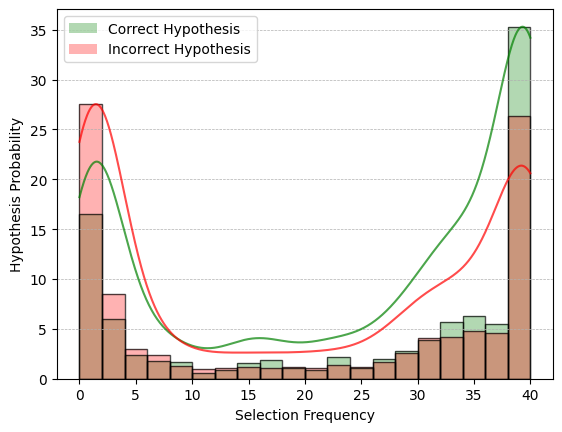

In [3]:
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, nu = 0.1, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [6]:
#Number of loops to ensure statistical significance
num_loops = 15
num_epochs = 200

hyperparameters = {"lr": {"value": 0.004}, "dropout": {"value": 0.05}, "nu": {"value": 0.1}}

In [ ]:
multi_experiments(num_loops, "use hypothesis", num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

In [11]:
%%capture
multi_experiments(num_loops, "partial info",   int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "use known only", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "full info",      int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

In [4]:
%%capture

for imput_method in ["Iterative MICE Imputer", "KNN Imputer", "Miss Forest", "Deep Regressor", "Soft Impute", 
                     "Matrix Factorization", "Hyperimpute"]: #, "Midas"
    counter = 0
    use_info = "use imputation" 
    num_epochs = 400
    for r_state in range(300):
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            counter += 1
            AM = AlgoModulators(DO, lr = 0.004)
            IMP = Imputer(DO)
            dataloader = IMP.impute_w_sel(DO, imput_method, batch_size)

            model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
            TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path,
                                        imput_method = imput_method, final_analysis = True)
            TVM.train_model(DO, AM, model, final_analysis = True)
            INSPECT.save_train_val_logs(DO, AM, TVM, model, imput_method, final_analysis = True)
        if counter == 15:
            break
            

In [5]:
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Iterative MICE Imputer,0.016980,0.002156
1,KNN Imputer,0.016257,0.002738
2,Miss Forest,0.015258,0.002656
3,Deep Regressor,0.022627,0.005959
4,Soft Impute,0.028848,0.002553
5,Matrix Factorization,0.028639,0.002506
6,Hyperimpute,0.016055,0.002955


In [18]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, 
                                                     partial_perc, batch_size, best_imput = "Miss Forest") #
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,Method,avg_r2_score,std_r2_score,avg_mse,std_mse,avg_mae,std_mae,explained_variance_scores
0,full info,0.796441,0.053849,0.006852,0.001987,0.060712,0.008477,0.797610
1,use hypothesis,0.681287,0.095496,0.010613,0.002920,0.079601,0.012127,0.693647
2,use known only,0.529300,0.090870,0.015791,0.003213,0.099698,0.010231,0.531127
3,partial info,0.398735,0.170307,0.019835,0.004081,0.109229,0.012135,0.419503
4,use imputation,0.526892,0.099825,0.015695,0.002642,0.096869,0.009231,0.541866
